# Fast Jaxified Qiskit Dynamics Simulation Workflow

Achieving 9ms simulations for Two Coupled Qutrit Hamiltonians

In [28]:
# All Imports

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

import qiskit
from qiskit import pulse

from qiskit_dynamics import Solver, DynamicsBackend
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit_dynamics.array import Array

from qiskit.quantum_info import Statevector, DensityMatrix, Operator
from qiskit.circuit.parameter import Parameter

import jax
import jax.numpy as jnp
from jax import jit, vmap, block_until_ready, config

import chex

from typing import Optional, Union

Array.set_default_backend('jax')
config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')

In [29]:
# Constructing a Two Qutrit Hamiltonian

dim = 3

v0 = 4.86e9
anharm0 = -0.32e9
r0 = 0.22e9

v1 = 4.97e9
anharm1 = -0.32e9
r1 = 0.26e9

J = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0 = np.kron(ident, N)
N1 = np.kron(N, ident)

a0 = np.kron(ident, a)
a1 = np.kron(a, ident)

a0dag = np.kron(ident, adag)
a1dag = np.kron(adag, ident)


static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

In [30]:
# Default Solver Options

y0 = Array(Statevector(np.ones(9)))
t_linspace = np.linspace(0.0, 200e-9, 11)
t_span = np.array([t_linspace[0], t_linspace[-1]])

dt = 1/4.5e9
atol = 1e-2
rtol = 1e-4

ham_ops = [drive_op0, drive_op1, drive_op0, drive_op1]
ham_chans = ["d0", "d1", "u0", "u1"]
chan_freqs = {"d0": v0, "d1": v1, "u0": v1, "u1": v0}

solver = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=ham_ops,
    rotating_frame=static_ham_full,
    hamiltonian_channels=ham_chans,
    channel_carrier_freqs=chan_freqs,
    dt=dt,
)

In [31]:
# Constructing General Gaussian Waveform

# Helper function that returns a lifted Gaussian symbolic equation.
def lifted_gaussian(
    t: sym.Symbol,
    center,
    t_zero,
    sigma,
) -> sym.Expr:
    t_shifted = (t - center).expand()
    t_offset = (t_zero - center).expand()

    gauss = sym.exp(-((t_shifted / sigma) ** 2) / 2)
    offset = sym.exp(-((t_offset / sigma) ** 2) / 2)

    return (gauss - offset) / (1 - offset)

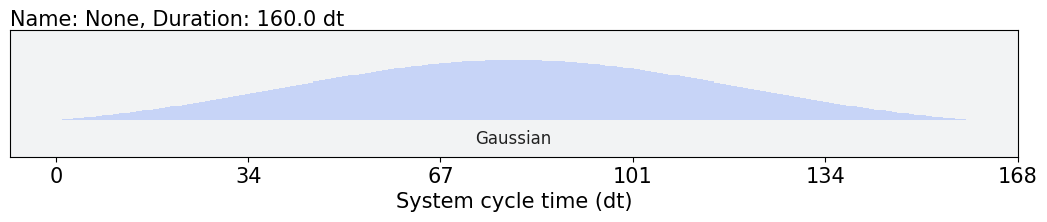

In [32]:
# Structure for Constructing New Pulse Waveform

_t, _duration, _amp, _sigma, _angle = sym.symbols("t, duration, amp, sigma, angle")
_center = _duration / 2

envelope_expr = (
    _amp * sym.exp(sym.I * _angle) * lifted_gaussian(_t, _center, _duration + 1, _sigma)
)

gaussian_pulse = pulse.ScalableSymbolicPulse(
        pulse_type="Gaussian",
        duration=160,
        amp=0.3,
        angle=0,
        parameters={"sigma": 40},
        envelope=envelope_expr,
        constraints=_sigma > 0,
        valid_amp_conditions=sym.Abs(_amp) <= 1.0,
    )

gaussian_pulse.draw()

In [33]:
# Constructing a custom function that takes as input a parameter vector and returns the simulated state

def standard_func(params):
    amp, sigma, freq = params

    # Here we use a Drag Pulse as defined in qiskit pulse as its already a scalable symbolic pulse
    # However we can equivalently use our own custom defined symbolic pulse
    special_pulse = pulse.Drag(
        duration=160,
        amp=amp,
        sigma=sigma,
        beta=0.1,
        angle=0.1,
        limit_amplitude=False
    )

    with pulse.build(default_alignment='sequential') as sched:
        d0 = pulse.DriveChannel(0)
        d1 = pulse.DriveChannel(1)
        u0 = pulse.ControlChannel(0)
        u1 = pulse.ControlChannel(1)

        pulse.shift_frequency(freq, d0)
        pulse.play(special_pulse, d0)

        pulse.shift_frequency(freq, d1)
        pulse.play(special_pulse, d1)

        pulse.shift_frequency(freq, u0)
        pulse.play(special_pulse, u0)

        pulse.shift_frequency(freq, u1)
        pulse.play(special_pulse, u1)
    
    return sched

def sim_func(params):
    sched = standard_func(params)

    converter = InstructionToSignals(dt, carriers=chan_freqs, channels=ham_chans)

    signals = converter.get_signals(sched)
    
    results = solver.solve(
        t_span=t_span,
        y0=y0,
        t_eval=t_linspace,
        signals=signals,
        rtol=rtol,
        atol=atol,
        convert_results=False,
        method='jax_odeint'
    )

    return results.y.data

fast_func = jit(vmap(sim_func))

batchsize = 400

amp_vals = jnp.linspace(0.0, 0.99, batchsize, dtype=jnp.float64).reshape(-1, 1)
sigma_vals = jnp.linspace(1, 40, batchsize, dtype=jnp.int8).reshape(-1, 1)
freq_vals = jnp.linspace(0.0, 0.99, batchsize, dtype=jnp.float64).reshape(-1, 1) * 1e6
batch_params = jnp.concatenate((amp_vals, sigma_vals, freq_vals), axis=-1)
print(f"Batched Params Shape: {batch_params.shape}")

res = fast_func(batch_params)

print(res)
print(res.shape)

# Timing the fast jit + vmap batched simulation
%timeit fast_func(batch_params).block_until_ready

Batched Params Shape: (400, 3)
[[[ 1.        +0.00000000e+00j  1.        +0.00000000e+00j
    1.        +0.00000000e+00j ...  1.        +0.00000000e+00j
    1.        +0.00000000e+00j  1.        +0.00000000e+00j]
  [ 1.        -1.09365151e-16j  1.        -3.31621913e-14j
    1.        +1.08335490e-13j ...  1.        +2.16261782e-13j
    1.        -3.19370096e-13j  1.        +2.42985407e-12j]
  [ 1.        -2.18730306e-16j  1.        -6.63243007e-14j
    1.        +2.16670994e-13j ...  1.        +4.32523698e-13j
    1.        -6.38740208e-13j  1.        +4.85970805e-12j]
  ...
  [ 1.        -8.74921304e-16j  1.        -2.65295238e-13j
    1.        +8.66684306e-13j ...  1.        +1.73009799e-12j
    1.        -2.55496121e-12j  1.        +1.94388302e-11j]
  [ 1.        -9.84286481e-16j  1.        -2.98456775e-13j
    1.        +9.75019907e-13j ...  1.        +1.94636084e-12j
    1.        -2.87433144e-12j  1.        +2.18686836e-11j]
  [ 1.        -1.09365166e-15j  1.        -3.31618229

In [35]:
# Timing a standard simulation without jitting or vmapping
%timeit sim_func(batch_params[200])

2.47 s ± 297 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Done!

The normal simulation takes 2.47s per simulation. Jit + Vmap + Batched evaluation reaches
3.62s for a batch of 400 different simulations, or in other words 9ms per simulation! Thats a factor of 275 improvement in speed!